# Problem 2. Incremental PCA

In [78]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Dataset

(2576, 520)
(1, 520)
Number of face labels: 52
Image label: 1


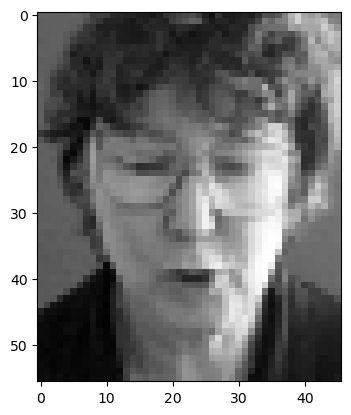

In [79]:
# Load Dataset
mat_file = io.loadmat('face.mat')

face_datas = mat_file['X']
face_labels = mat_file['l']

print(face_datas.shape) #520개의 image
print(face_labels.shape) #520개의 label
print("Number of face labels: {}".format(len(np.unique(face_labels))))

#Loading one image
imgnumn = 0
face_n = face_datas[:,imgnumn]
face_n = np.reshape(face_n,(46,56)).T
print("Image label: {}".format(face_labels[0,imgnumn]))
plt.imshow(face_n, cmap = 'gist_gray')


In [80]:
#train-test split : 8 / 2 images for each ID
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
train_index, test_index = next(sss.split(face_datas.T, face_labels.T))

X_train, X_test = face_datas.T[train_index], face_datas.T[test_index]
y_train, y_test = face_labels.T[train_index], face_labels.T[test_index]

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(416, 2576) (104, 2576) (416, 1) (104, 1)


(2576,)


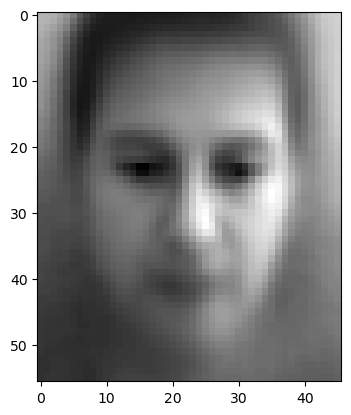

In [81]:
#Obtaining mean image
avg_face_numpy = np.mean(X_train, axis=0)
print(avg_face_numpy.shape)

plt.imshow(np.reshape(avg_face_numpy,(46,56)).T, cmap = 'gist_gray')

# PCA using SKlearn

In [82]:
params = {
    'n_pca' : 200,
    'batch_ipca' : 4,
    'n_ipca' : 100,
}

In [83]:
# PCA using SKlearn
h, w = 46, 56
n_components = params['n_pca']

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time.time()
pca = PCA(n_components=n_components).fit(X_train)
print("done in %0.3fs" % (time.time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time.time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time.time() - t0))


Extracting the top 200 eigenfaces from 416 faces
done in 0.465s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.020s


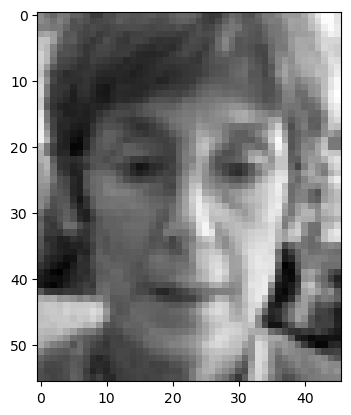

In [84]:
#Reconstruction
X_train_reconst = pca.inverse_transform(X_train_pca)
X_train_reconst_error = abs(X_train - X_train_reconst)

#print(X_train_reconst_error)
plt.imshow(np.reshape(X_train_reconst[0],(46,56)).T, cmap = 'gist_gray')

In [85]:
print("Fitting the classifier to the training set")
t0 = time.time()
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train_pca, y_train.flatten())
print("done in %0.3fs" % (time.time() - t0))
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred))

Fitting the classifier to the training set
done in 0.001s
              precision    recall  f1-score   support

           1       0.67      1.00      0.80         2
           2       1.00      0.50      0.67         2
           3       0.67      1.00      0.80         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       0.50      1.00      0.67         2
           7       1.00      0.50      0.67         2
           8       0.50      1.00      0.67         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       0.50      0.50      0.50         2
          12       0.67      1.00      0.80         2
          13       1.00      0.50      0.67         2
          14       1.00      0.50      0.67         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       0.50

# Incremental PCA

In [86]:
n_components = params['n_ipca']
n_batch = params['batch_ipca']
N_train = X_train.shape[0]

print(
    "Extracting the top %d eigenfaces from %d faces per batch" % (n_components, X_train.shape[0]//4)
)
t0 = time.time()
ipca = IncrementalPCA(n_components=n_components, batch_size=(N_train//n_batch)).fit(X_train)
print("done in %0.3fs" % (time.time() - t0))

eigenfaces = ipca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time.time()
X_train_ipca = ipca.transform(X_train)
X_test_ipca = ipca.transform(X_test)
print("done in %0.3fs" % (time.time() - t0))

Extracting the top 100 eigenfaces from 104 faces per batch
done in 1.037s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.014s


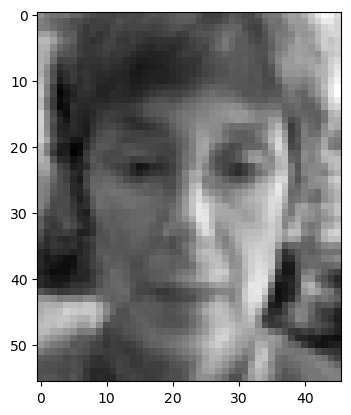

In [87]:
#Reconstruction
X_train_reconst_ipca = ipca.inverse_transform(X_train_ipca)
X_train_reconst_error_ipca = abs(X_train - X_train_reconst_ipca)

#print(X_train_reconst_error_ipca)
plt.imshow(np.reshape(X_train_reconst_ipca[0],(46,56)).T, cmap = 'gist_gray')

In [88]:
print("Fitting the classifier to the training set")
t0 = time.time()
clf_ipca = KNeighborsClassifier(n_neighbors=1)
clf_ipca.fit(X_train_ipca, y_train.flatten())
print("done in %0.3fs" % (time.time() - t0))

Fitting the classifier to the training set
done in 0.001s


In [89]:
y_pred = clf_ipca.predict(X_test_ipca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.67      1.00      0.80         2
           2       0.00      0.00      0.00         2
           3       0.67      1.00      0.80         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       0.50      1.00      0.67         2
           7       1.00      0.50      0.67         2
           8       0.50      1.00      0.67         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       0.50      0.50      0.50         2
          12       1.00      1.00      1.00         2
          13       0.50      0.50      0.50         2
          14       1.00      0.50      0.67         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       0.50      0.50      0.50         2
          18       1.00    

# PCA using first-batch

In [90]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=0)
train_index, test_index = next(sss.split(X_train, y_train))

X_train_batch_1 = X_train[test_index]
y_train_batch_1 = y_train[test_index]

print(X_train_batch_1.shape,y_train_batch_1.shape)

(104, 2576) (104, 1)


Extracting the top 100 eigenfaces from 104 faces
done in 0.148s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s


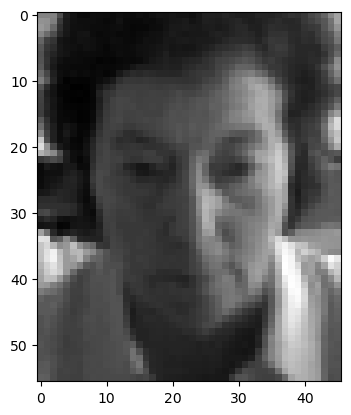

In [91]:
n_components = params['n_ipca']


print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train_batch_1.shape[0])
)
t0 = time.time()
pca_first = PCA(n_components=n_components).fit(X_train_batch_1)
print("done in %0.3fs" % (time.time() - t0))

eigenfaces = pca_first.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time.time()
X_train_pca_first = pca_first.transform(X_train_batch_1)
X_test_pca_first = pca_first.transform(X_test)
print("done in %0.3fs" % (time.time() - t0))

#Reconstruction
X_train_reconst_first = pca_first.inverse_transform(X_train_pca_first)
X_train_reconst_error_first = abs(X_train_batch_1 - X_train_reconst_first)

#print(X_train_reconst_error)
plt.imshow(np.reshape(X_train_reconst_first[0],(46,56)).T, cmap = 'gist_gray')


In [92]:
print("Fitting the classifier to the training set")
t0 = time.time()
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train_pca_first, y_train_batch_1.flatten())
print("done in %0.3fs" % (time.time() - t0))
y_pred = clf.predict(X_test_pca_first)
print(classification_report(y_test, y_pred))

Fitting the classifier to the training set
done in 0.002s
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.33      0.50      0.40         2
           5       0.00      0.00      0.00         2
           6       0.33      0.50      0.40         2
           7       0.50      0.50      0.50         2
           8       0.25      0.50      0.33         2
           9       0.00      0.00      0.00         2
          10       1.00      0.50      0.67         2
          11       0.50      0.50      0.50         2
          12       0.67      1.00      0.80         2
          13       0.50      0.50      0.50         2
          14       0.00      0.00      0.00         2
          15       1.00      0.50      0.67         2
          16       0.50      0.50      0.50         2
          17       0.25